In [1]:
## importing modules
import string
import re
import random
import collections

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchmetrics.classification import BinaryF1Score
from transformers import AutoTokenizer

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

In [2]:
all_df = pd.read_csv("/kaggle/input/provider-preprocessed/preprocessed_df_ft.csv")

# split data
X = all_df["clean_text"]
y = all_df["sentiment"]

def encode_label(label):
    if label == 'positif':
        return 1
    else:
        return 0

y = y.apply(lambda x: encode_label(x))

train_df, X_test, train_label, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(train_df, train_label, test_size=0.2, random_state=0)

In [3]:
print(f"Train-val data size: {len(train_df)}")
print(f"Train data size: {len(X_train)}")
print(f"Validation data label: {len(X_val)}")
print(f"Test data size: {len(X_test)}")

Train-val data size: 1724
Train data size: 1379
Validation data label: 345
Test data size: 192


In [4]:
import string
import torch
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

#####
# Document Sentiment
#####
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'positif': 1, 'negatif': 0}
    INDEX2LABEL = {1: 'positif', 0: 'negatif'}
    NUM_LABELS = 2
    
    def load_dataset(self, path): 
        df = pd.read_csv(path)
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['clean_text'], data['sentiment']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['clean_text']
    
    def __len__(self):
        return len(self.data)    
        
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, sentiment_batch, seq_list
    
# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label


def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

## indobert-base-p2

In [6]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2")
config.num_labels = 2

# Instantiate model
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p2", config=config
)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
set_seed(1352)

In [8]:
pd.concat([X_train,y_train],axis=1).reset_index(drop=True).to_csv("train_1.csv",index=False)
pd.concat([X_val,y_val],axis=1).reset_index(drop=True).to_csv("validation_1.csv",index=False)
pd.concat([X_test,y_test],axis=1).reset_index(drop=True).to_csv("test_1.csv",index=False)

In [9]:
train_dataset_path = './train_1.csv'
valid_dataset_path = "./validation_1.csv"

train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=0, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=0, shuffle=False)  

In [10]:
w2i = {"negatif" : 0, "positif" : 1}
i2w = {0:"negatif", 1:"positif"}

optimizer = optim.Adam(model.parameters(), lr=2e-6)
model = model.cuda()

In [11]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from tqdm import tqdm

train_loss_plot = []
valid_loss_plot = []

# Train
n_epochs = 6
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                       i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                       i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), 
                                                           metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    #Tracking of Loss
    train_loss_plot.append(total_train_loss/len(train_pbar))
    valid_loss_plot.append(total_loss/len(pbar))

(Epoch 1) TRAIN LOSS:0.3087 LR:0.00000200: 100%|██████████| 173/173 [00:17<00:00, 10.01it/s]


(Epoch 1) TRAIN LOSS:0.3087 ACC:0.8970 F1:0.8562 REC:0.8234 PRE:0.9189 LR:0.00000200


VALID LOSS:0.1615 ACC:0.9275 F1:0.9077 REC:0.8860 PRE:0.9399: 100%|██████████| 44/44 [00:01<00:00, 30.19it/s]


(Epoch 1) VALID LOSS:0.1615 ACC:0.9275 F1:0.9077 REC:0.8860 PRE:0.9399


(Epoch 2) TRAIN LOSS:0.1219 LR:0.00000200: 100%|██████████| 173/173 [00:16<00:00, 10.36it/s]


(Epoch 2) TRAIN LOSS:0.1219 ACC:0.9572 F1:0.9458 REC:0.9404 PRE:0.9517 LR:0.00000200


VALID LOSS:0.1233 ACC:0.9652 F1:0.9580 REC:0.9554 PRE:0.9607: 100%|██████████| 44/44 [00:01<00:00, 31.69it/s]


(Epoch 2) VALID LOSS:0.1233 ACC:0.9652 F1:0.9580 REC:0.9554 PRE:0.9607


(Epoch 3) TRAIN LOSS:0.0786 LR:0.00000200: 100%|██████████| 173/173 [00:16<00:00, 10.29it/s]


(Epoch 3) TRAIN LOSS:0.0786 ACC:0.9746 F1:0.9681 REC:0.9654 PRE:0.9708 LR:0.00000200


VALID LOSS:0.1583 ACC:0.9391 F1:0.9235 REC:0.9056 PRE:0.9479: 100%|██████████| 44/44 [00:01<00:00, 31.21it/s]


(Epoch 3) VALID LOSS:0.1583 ACC:0.9391 F1:0.9235 REC:0.9056 PRE:0.9479


(Epoch 4) TRAIN LOSS:0.0521 LR:0.00000200: 100%|██████████| 173/173 [00:17<00:00, 10.09it/s]


(Epoch 4) TRAIN LOSS:0.0521 ACC:0.9840 F1:0.9799 REC:0.9768 PRE:0.9832 LR:0.00000200


VALID LOSS:0.1314 ACC:0.9623 F1:0.9544 REC:0.9505 PRE:0.9585: 100%|██████████| 44/44 [00:01<00:00, 30.69it/s]


(Epoch 4) VALID LOSS:0.1314 ACC:0.9623 F1:0.9544 REC:0.9505 PRE:0.9585


(Epoch 5) TRAIN LOSS:0.0269 LR:0.00000200: 100%|██████████| 173/173 [00:17<00:00,  9.96it/s]


(Epoch 5) TRAIN LOSS:0.0269 ACC:0.9942 F1:0.9927 REC:0.9919 PRE:0.9935 LR:0.00000200


VALID LOSS:0.1439 ACC:0.9565 F1:0.9482 REC:0.9521 PRE:0.9446: 100%|██████████| 44/44 [00:01<00:00, 30.66it/s]


(Epoch 5) VALID LOSS:0.1439 ACC:0.9565 F1:0.9482 REC:0.9521 PRE:0.9446


(Epoch 6) TRAIN LOSS:0.0210 LR:0.00000200: 100%|██████████| 173/173 [00:17<00:00,  9.87it/s]


(Epoch 6) TRAIN LOSS:0.0210 ACC:0.9964 F1:0.9955 REC:0.9951 PRE:0.9959 LR:0.00000200


VALID LOSS:0.2140 ACC:0.9362 F1:0.9201 REC:0.9035 PRE:0.9423: 100%|██████████| 44/44 [00:01<00:00, 30.08it/s]

(Epoch 6) VALID LOSS:0.2140 ACC:0.9362 F1:0.9201 REC:0.9035 PRE:0.9423


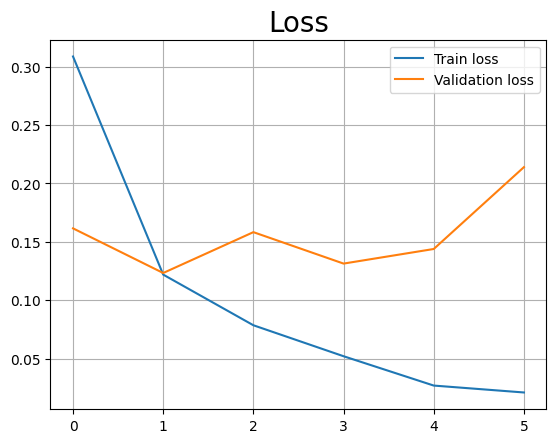

In [12]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize = (20, 6))
# plt.subplot(1, 2, 1)
# plt.plot(model_pretrain_we['train_f1score'], label='Train F1-score')
# plt.plot(model_pretrain_we['val_f1score'], label='Validation F1-score')
# plt.title("F1-score", fontsize=20)
# plt.legend()
# plt.grid()

# plt.subplot(1, 2, 2)
plt.plot(train_loss_plot, label='Train loss')
plt.plot(valid_loss_plot, label='Validation loss')
plt.title("Loss", fontsize=20)
plt.legend()
plt.grid()

plt.show()

In [13]:
test_dataset_path = "./test_1.csv"
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=1, num_workers=0, shuffle=False)  

In [14]:
# Evaluate on validation
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = (batch_data)[-1]        
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                   i2w=i2w, device='cuda')

    # Calculate total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)

    pbar.set_description("TEST LOSS:{:.4f} {}".format(total_loss/(i+1), 
                                                       metrics_to_string(metrics)))

metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print("TEST LOSS:{:.4f} {}".format(
    total_loss/(i+1), metrics_to_string(metrics)))

TEST LOSS:0.1186 ACC:0.9792 F1:0.9745 REC:0.9695 PRE:0.9799: 100%|██████████| 192/192 [00:03<00:00, 55.92it/s]


TEST LOSS:0.1186 ACC:0.9792 F1:0.9745 REC:0.9695 PRE:0.9799


In [16]:
torch.save(model.state_dict(), "provider-indobert-base.pt")

In [17]:
from IPython.display import FileLink

FileLink(r'provider-indobert-base.pt')

/kaggle/working/provider-indobert-base.pt

## indobert-large-p2

In [74]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-large-p2")
config = BertConfig.from_pretrained("indobenchmark/indobert-large-p2")
config.num_labels = 2

# Instantiate model
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-large-p2", config=config)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
set_seed(1352)

In [76]:
w2i = {"negatif" : 0, "positif" : 1}
i2w = {0:"negatif", 1:"positif"}

optimizer = optim.Adam(model.parameters(), lr=2e-6)
model = model.cuda()

In [78]:
train_loss_plot = []
valid_loss_plot = []

# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                       i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                       i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), 
                                                           metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    #Tracking of Loss
    train_loss_plot.append(total_train_loss/len(train_pbar))
    valid_loss_plot.append(total_loss/len(pbar))

(Epoch 1) TRAIN LOSS:0.4109 LR:0.00000200: 100%|██████████| 173/173 [00:56<00:00,  3.06it/s]


(Epoch 1) TRAIN LOSS:0.4109 ACC:0.7955 F1:0.6556 REC:0.6380 PRE:0.8500 LR:0.00000200


VALID LOSS:0.2349 ACC:0.9271 F1:0.9065 REC:0.8855 PRE:0.9372: 100%|██████████| 192/192 [00:05<00:00, 35.01it/s]


(Epoch 1) VALID LOSS:0.2349 ACC:0.9271 F1:0.9065 REC:0.8855 PRE:0.9372


(Epoch 2) TRAIN LOSS:0.1798 LR:0.00000200: 100%|██████████| 173/173 [00:55<00:00,  3.09it/s]


(Epoch 2) TRAIN LOSS:0.1798 ACC:0.9507 F1:0.9374 REC:0.9310 PRE:0.9444 LR:0.00000200


VALID LOSS:0.1275 ACC:0.9740 F1:0.9683 REC:0.9659 PRE:0.9709: 100%|██████████| 192/192 [00:05<00:00, 34.52it/s]


(Epoch 2) VALID LOSS:0.1275 ACC:0.9740 F1:0.9683 REC:0.9659 PRE:0.9709


(Epoch 3) TRAIN LOSS:0.1143 LR:0.00000200: 100%|██████████| 173/173 [00:55<00:00,  3.11it/s]


(Epoch 3) TRAIN LOSS:0.1143 ACC:0.9630 F1:0.9534 REC:0.9501 PRE:0.9569 LR:0.00000200


VALID LOSS:0.1057 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748: 100%|██████████| 192/192 [00:05<00:00, 35.32it/s]


(Epoch 3) VALID LOSS:0.1057 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748


(Epoch 4) TRAIN LOSS:0.0781 LR:0.00000200: 100%|██████████| 173/173 [00:54<00:00,  3.15it/s]


(Epoch 4) TRAIN LOSS:0.0781 ACC:0.9732 F1:0.9663 REC:0.9636 PRE:0.9690 LR:0.00000200


VALID LOSS:0.0945 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748: 100%|██████████| 192/192 [00:05<00:00, 34.00it/s]


(Epoch 4) VALID LOSS:0.0945 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748


(Epoch 5) TRAIN LOSS:0.0597 LR:0.00000200: 100%|██████████| 173/173 [00:57<00:00,  3.03it/s]


(Epoch 5) TRAIN LOSS:0.0597 ACC:0.9804 F1:0.9753 REC:0.9719 PRE:0.9790 LR:0.00000200


VALID LOSS:0.0930 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748: 100%|██████████| 192/192 [00:05<00:00, 35.46it/s]

(Epoch 5) VALID LOSS:0.0930 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748


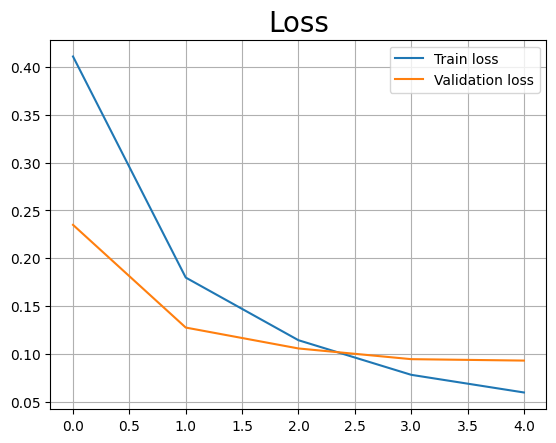

In [79]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize = (20, 6))
# plt.subplot(1, 2, 1)
# plt.plot(model_pretrain_we['train_f1score'], label='Train F1-score')
# plt.plot(model_pretrain_we['val_f1score'], label='Validation F1-score')
# plt.title("F1-score", fontsize=20)
# plt.legend()
# plt.grid()

# plt.subplot(1, 2, 2)
plt.plot(train_loss_plot, label='Train loss')
plt.plot(valid_loss_plot, label='Validation loss')
plt.title("Loss", fontsize=20)
plt.legend()
plt.grid()

plt.show()

In [80]:
# Evaluate on validation
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = (batch_data)[-1]        
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], 
                                                                   i2w=i2w, device='cuda')

    # Calculate total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)

    pbar.set_description("TEST LOSS:{:.4f} {}".format(total_loss/(i+1), 
                                                       metrics_to_string(metrics)))

metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print("TEST LOSS:{:.4f} {}".format(
    total_loss/(i+1), metrics_to_string(metrics)))

TEST LOSS:0.0930 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748: 100%|██████████| 192/192 [00:05<00:00, 35.74it/s]

TEST LOSS:0.0930 ACC:0.9792 F1:0.9748 REC:0.9748 PRE:0.9748


In [81]:
torch.save(model.state_dict(), "provider-indobert-large.pt")

In [83]:
from IPython.display import FileLink

FileLink(r'provider-indobert-large.pt')

/kaggle/working/provider-indobert-large.pt